**student**: Titouan Le Breton

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

# Exercise 1.A

### Question 1

A gibbs sampler is a sampling one cordinate conditionaly on the others. Sometimes, you can't sample this conditional, so you need MH.

It seems we select one o fthe indexes at random.


Here, we use MH to sample tehe condtional distribution pi(x_i|x_-i)

so the algirthm is: 

for step in n:
    sample i form 1,2
    update x_i with MH

P_1 and P_2 sample the first and second coordinate respectively. However, they take as input z in R2.... which will have one of this coordinates unchanged

we are in the case where pi(x_prop|y) / pi(x|y) = pi(x_prop, y) / pi(x, y)

This algoirthm is a gibbs sampler because x is update conditionally on y and vice-versa. It is called random becasue at each iteration, wether x or y is updated is random (50% chance for each). 

Once which coordinate is going to be updated is determined, Metropolis-Hastings sampling is used

### Question 2

In [3]:
def pi(x,y , a=10):
    store_var = -np.power(x,2) / a**2 - np.power(y,2) - 0.25*np.power(np.power(x,2)/a**2 - np.power(y,2) ,2)
    return np.exp(store_var)

In [ ]:
def sample_P1(x, y, sigma_1, pi):
    x_prop = x + np.random.normal(0, sigma_1)
    alpha = min(1, pi(x_prop, y) / pi(x, y))

    if np.random.rand() < alpha:
        return x_prop, y
    else:
        return x, y


def sample_P2(x, y, sigma_2, pi):
    y_prop = y + np.random.normal(0, sigma_2)
    alpha = min(1, pi(x, y_prop) / pi(x, y))

    if np.random.rand() < alpha:
        return x, y_prop
    else:
        return x, y
    
def MH_with_gibs(sigma_1, sigma_2, pi, N_steps, return_acceptance_ratio = False):
    x = np.random.randn()
    y = np.random.randn()

    # we track the number of times each variables was accepeted (this is usefull to understand how the sampler is behaving)
    count_x_accepted = 0
    count_y_accepted = 0
    count_x_proposed = 0
    count_y_proposed = 0

    x_list = [x]
    y_list = [y]

    for i in range(N_steps):
        x_old, y_old = x, y

        # choose which coordinate to update
        if np.random.rand() < 0.5:
            count_x_proposed += 1
            x, y = sample_P1(x, y, sigma_1, pi)
            if x != x_old:
                count_x_accepted += 1
        else:
            count_y_proposed += 1
            x, y = sample_P2(x, y, sigma_2, pi)
            if y != y_old:
                count_y_accepted += 1

        x_list.append(x)
        y_list.append(y)

    if return_acceptance_ratio:
        acc_x = count_x_accepted / count_x_proposed
        acc_y = count_y_accepted / count_y_proposed
        return x_list, y_list, acc_x, acc_y
    else:
        return x_list, y_list




### Question 3

Acceptance ratio x: 0.847
Acceptance ratio y: 0.270


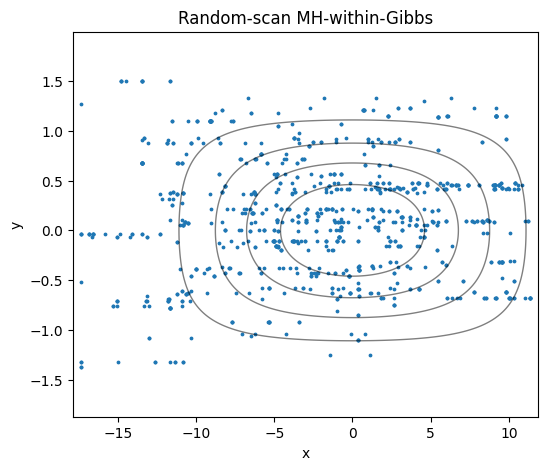

In [34]:
def plot_sampler(sampler, density, sigma_1, sigma_2, a=10, N_steps=2000, title=None):
    x_list, y_list, acc_x, acc_y = sampler(
        sigma_1, sigma_2, density, N_steps, return_acceptance_ratio=True
    )

    print(f"Acceptance ratio x: {acc_x:.3f}")
    print(f"Acceptance ratio y: {acc_y:.3f}")

    burn_in = min(1000, N_steps//2)
    x_arr = np.array(x_list[burn_in:])
    y_arr = np.array(y_list[burn_in:])

    x_min, x_max = x_arr.min(), x_arr.max()
    y_min, y_max = y_arr.min(), y_arr.max()

    x_grid = np.linspace(x_min - 0.5, x_max + 0.5, 200)
    y_grid = np.linspace(y_min - 0.5, y_max + 0.5, 200)
    X, Y = np.meshgrid(x_grid, y_grid)

    Z = pi(X, Y, a=a)  

    plt.figure(figsize=(6, 5))
    plt.contour(X, Y, Z, levels=5, colors='black', linewidths=1, alpha=0.5)
    plt.scatter(x_arr, y_arr, s=3)
    plt.xlabel("x")
    plt.ylabel("y")
    if title is not None:
        plt.title(title)
    plt.show()


sigma_1 = 3
sigma_2 = 3
plot_sampler(MH_with_gibs, pi, sigma_1, sigma_2, title="Random-scan MH-within-Gibbs")

### Q4

We do not get good results. We move a lot on x, but not a lot on y. So we accept a lot on x but not on y (we get horiztional lines). It is an issue of variance: it is too small on the x (we accept to often) and to big on y (the proposition are too drasticall and we reject too often)

To improve performance, we can make sigma_1 larger (accept x less often) and sigma_2 smaller (accept y more often).


To check the quality of the markov chain, you can do an autocorrelation plot (you want it to go to 0 when the lag is large so you get indepndence)

Acceptance ratio x: 0.737
Acceptance ratio y: 0.405


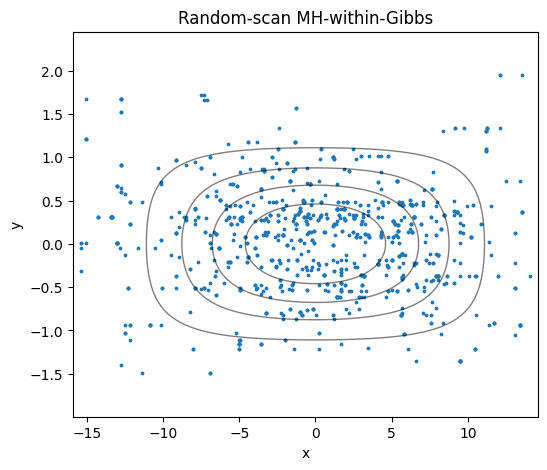

In [35]:
sigma_1 = 6
sigma_2 = 2
plot_sampler(MH_with_gibs, pi, sigma_1, sigma_2, title="Random-scan MH-within-Gibbs")

# Exercise 1.B

The idea is to modify the variances to always have an acceptable acceptance rate (around 0.25%)

### Question 1

same as before, but after 50 steps we change the variance

Note: in practice, we look at effective acceptance ratio (not the average alphas)

Acceptance ratio x: 0.220
Acceptance ratio y: 0.220


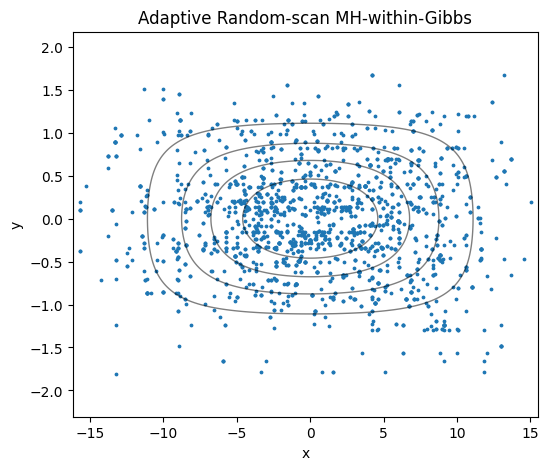

In [36]:
def update_variance(sigma_1, sigma_2, x_acceptance_ratio, y_acceptance_ratio, sigma_j, golden_ratio):
    log_sigma_1 = np.log(sigma_1)
    log_sigma_2 = np.log(sigma_2)

    if x_acceptance_ratio > golden_ratio:
        log_sigma_1 += sigma_j
    else:
        log_sigma_1 -= sigma_j

    if y_acceptance_ratio > golden_ratio:
        log_sigma_2 += sigma_j
    else:
        log_sigma_2 -= sigma_j

    sigma_1 = np.exp(log_sigma_1)
    sigma_2 = np.exp(log_sigma_2)
    return sigma_1, sigma_2


def adaptive_MH_with_gibs(sigma_1, sigma_2, pi, N_batches, return_acceptance_ratio = False):
    x_list = []
    y_list = []
    N_steps = 50
    golden_ratio = 0.234

    x = np.random.randn()
    y = np.random.randn()
    x_list.append(x)
    y_list.append(y)

    for j in range(1, N_batches + 1):
        count_x_accepted = 0
        count_y_accepted = 0

        for _ in range(N_steps):
            x_old, y_old = x, y

            if np.random.rand() < 0.5:
                x, y = sample_P1(x, y, sigma_1, pi)
                if x != x_old:
                    count_x_accepted += 1
            else:
                x, y = sample_P2(x, y, sigma_2, pi)
                if y != y_old:
                    count_y_accepted += 1

            x_list.append(x)
            y_list.append(y)

        x_acceptance_ratio = count_x_accepted / N_steps
        y_acceptance_ratio = count_y_accepted / N_steps

        sigma_j = min(0.05, j**(-0.5))
        sigma_1, sigma_2 = update_variance(
            sigma_1, sigma_2, x_acceptance_ratio, y_acceptance_ratio, sigma_j, golden_ratio
        )
    if return_acceptance_ratio:
        return x_list, y_list, x_acceptance_ratio, y_acceptance_ratio
    else:   
        return x_list, y_list

sigma_1 = 3
sigma_2 = 3
plot_sampler(adaptive_MH_with_gibs, pi, sigma_1, sigma_2,N_steps= 2000//50, title="Adaptive Random-scan MH-within-Gibbs")

Just from the scatter plot, we observce that this addaptive sampling matches the true distribution $\pi$ much more closely. We look at the auto-convariances to get a numerical indicator of performance:

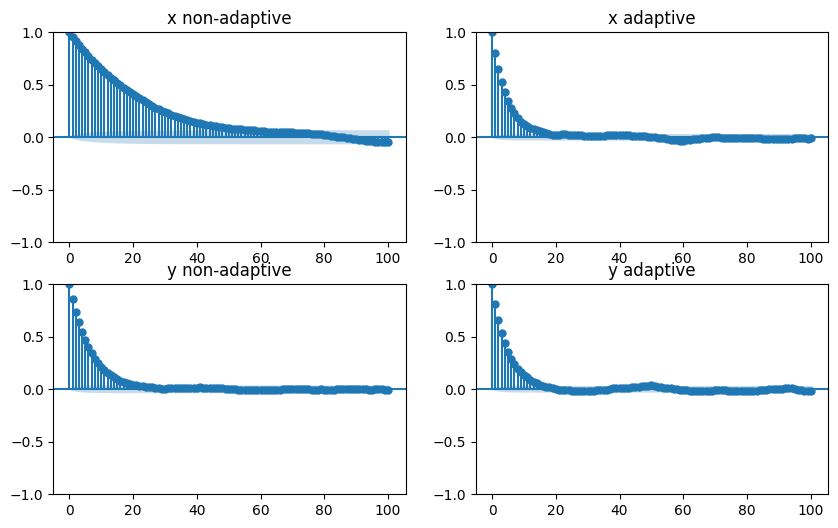

In [32]:
def compare_acf(MH_with_gibs, adaptive_MH_with_gibs, sigma_1, sigma_2, dist):
    total_steps = 20000
    N_batches = total_steps // 50
    x_na, y_na = MH_with_gibs(sigma_1, sigma_2, dist, total_steps, return_acceptance_ratio=False)
    x_ad, y_ad = adaptive_MH_with_gibs(sigma_1, sigma_2, dist, N_batches, return_acceptance_ratio=False)

    burn = 1000
    x_na = np.array(x_na[burn:])
    y_na = np.array(y_na[burn:])
    x_ad = np.array(x_ad[burn:])
    y_ad = np.array(y_ad[burn:])

    max_lag = 100

    fig, axes = plt.subplots(2, 2, figsize=(10, 6))
    plot_acf(x_na, lags=max_lag, ax=axes[0, 0])
    axes[0, 0].set_title("x non-adaptive")
    plot_acf(x_ad, lags=max_lag, ax=axes[0, 1])
    axes[0, 1].set_title("x adaptive")
    plot_acf(y_na, lags=max_lag, ax=axes[1, 0])
    axes[1, 0].set_title("y non-adaptive")
    plot_acf(y_ad, lags=max_lag, ax=axes[1, 1])
    axes[1, 1].set_title("y adaptive")
    plt.show()

sigma_1 = 3
sigma_2 = 3
compare_acf(MH_with_gibs, adaptive_MH_with_gibs, sigma_1, sigma_2, pi)


With the adaptive sampling, autocorrelation decreases much faster, especially on x. As such, adaptive sampling does improve performance

### Question 2

Acceptance ratio x: 0.337
Acceptance ratio y: 0.396


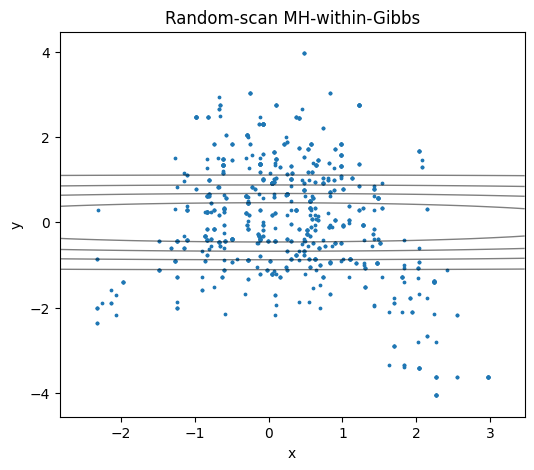

Acceptance ratio x: 0.280
Acceptance ratio y: 0.240


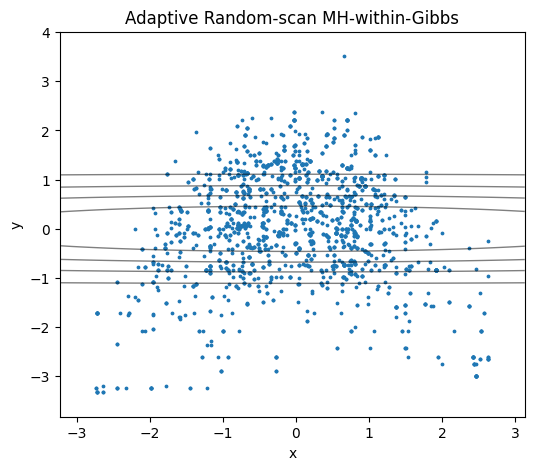

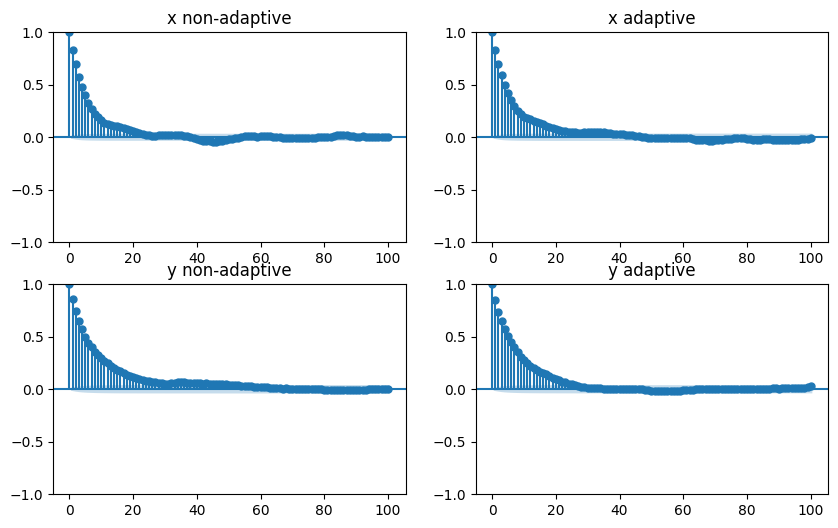

In [37]:
def pi_banana(x, y, B=0.4):
    store_var = -0.5 * x**2 - 0.5 * (y + B * x**2 - B)**2
    return np.exp(store_var)

sigma_1 = 3
sigma_2 = 3

plot_sampler(MH_with_gibs, pi_banana, sigma_1, sigma_2, title="Random-scan MH-within-Gibbs")
plot_sampler(adaptive_MH_with_gibs, pi_banana, sigma_1, sigma_2,N_steps= 2000//50, title="Adaptive Random-scan MH-within-Gibbs")
compare_acf(MH_with_gibs, adaptive_MH_with_gibs, sigma_1, sigma_2, pi_banana)


In the instance of the "banana" density, the performance gaisn from adaptive distrubtion are less pronounced, but we do observe that the acceptance ratio is closer to the ideal value of 0.234

# Exercise 2.A

### Question 1

In [8]:
mu = np.array([
    [2.18, 5.76], [8.67, 9.59], [4.24, 8.48], [8.41, 1.68], [3.93, 8.82], [3.25, 3.47], [1.70, 0.50], [4.59, 5.60], [6.91, 5.81], [6.87, 5.40],[5.41, 2.65],
    [2.70, 7.88],[4.98, 3.70],[1.14, 2.39],[8.33, 9.50],[4.93, 1.50],[1.83, 0.09],[2.26, 0.31],[5.54, 6.86],[1.69, 8.11]
])

In [9]:
mu.shape

(20, 2)

In [10]:
sigma = 0.1
w = 0.05

x = np.array([1,-2])
X = np.tile(x, (20, 1))


exp_matrix = np.exp( (X - mu) @ (X - mu).T / (-2 * sigma**2))
exp_matrix.shape

(20, 20)

# Exercise 2.B

### Question 1